# Prompt engineering with Llama 3.2 - 3B

In this lab, we will explore prompt engineering for large language models (LLMs) using [LLaMA 3.2 (3B) - Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct). This is a model fine-tuned to follow instructions.

We will start by installing and importing the required libraries.

In [ ]:
!pip install transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Imports
import numpy as np
import os
import pandas as pd

# Set environmental variables
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "300"  # Set timeout to 5 minutes

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import graphviz
from matplotlib.colors import ListedColormap
graphviz.set_jupyter_format('png')
%matplotlib inline

# Import Pytorch lybraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import _LRScheduler

# Huggingface
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from transformers import pipeline
from transformers import set_seed
import accelerate

# XGBoost
from xgboost import XGBClassifier

# Markdown for format
from IPython.display import Markdown, display

# Shap values
import shap


## Basic prompt engineering

To optimize model execution, we use Hugging Face's Accelerate library, which helps efficiently manage device placement (CPU/GPU).

In [ ]:
# Add accelerator
accelerator = accelerate.Accelerator()
device = accelerator.device

Before accessing restricted models or using private repositories, we need to authenticate with Hugging Face Hub.

How to Get Your Token?

Visit [Hugging Face Token Page](https://huggingface.co/settings/tokens).
Generate a new token (select "Write" permissions if needed, normally you would need just "Read" permissions). You can save this value in an environmental variable "HF_TOKEN", or in a [Colab secret](https://huggingface.co/docs/huggingface_hub/v0.23.4/quick-start).
Once logged in, you can download gated models, access private datasets, and use Hugging Face services seamlessly.

The following command prompts for your Hugging Face access token to enable secure model downloads and API access.

In [ ]:
# Login to huggingface.
login()

In this step, we load the LLaMA 3.2 (3B)-Instruct model using Hugging Face's transformers library and configure it for optimized execution on Google Colab's GPU.

* The model we are using is LLaMA 3.2 (3B) Instruct, a fine-tuned version designed for instruction-following tasks.
* We use [bfloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format) (Brain Floating Point 16-bit), a precision format that improves memory efficiency while maintaining accuracy.

Downloading the model will take approximately 3 minutes.

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
dtype = torch.bfloat16

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype, device_map="auto")
model = accelerator.prepare(model)  # Ensure model is placed on the correct device

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

The following code displays the chat template used by the LLaMA 3.2 (1B) Instruct model to format conversations.

What is a Chat Template?

A chat template defines the structure of input messages before they are passed to the model. It ensures that the model correctly interprets the conversation flow and generates appropriate responses.

If a chat template is not available, prompts must be manually formatted.
In our case, we have a predefined chat template, simplifying the process.

In [ ]:
print(tokenizer.chat_template)

{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- 

This code ensures that both the tokenizer and model configuration have a defined padding token to handle variable-length inputs properly.

In [ ]:
# Ensure tokenizer has a padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

Now, we initialize a text generation pipeline using the Hugging Face **`transformers`** library.

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=dtype,
    device_map="auto",
)

Device set to use cuda:0


Then, we format a conversation into a structured prompt using a chat template for the model.

* The system message sets the model’s behavior.
* The user message provides the specific query.

In [ ]:
# Example Input
system_message = "You are an expert assistant specializing in Banking Analytics and Business Analytics. Provide structured and factual responses."
user_prompt = "Explain the key differences between Banking Analytics and Business Analytics"

messages = [
    {
        "role": "system",
        "content": system_message,
    },
    {
        "role": "user",
        "content": user_prompt,
    },
]

prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

prompt

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 03 Apr 2025\n\nYou are an expert assistant specializing in Banking Analytics and Business Analytics. Provide structured and factual responses.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nExplain the key differences between Banking Analytics and Business Analytics<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

The following code generates text using a pre-trained language model via the pipe (text generation pipeline) and prints the generated response.


* max_new_tokens=512 → Limits the response length to 512 tokens.
* do_sample=True → Enables sampling (randomness) instead of deterministic outputs.
* top_p=0.8 → Uses nucleus sampling, meaning the model selects from the top 80% probability mass.
* temperature=0.2 → Controls randomness:

    Lower values (e.g., 0.2) → More focused and  deterministic responses.

    Higher values (e.g., 1.0) → More creative and diverse responses.

* repetition_penalty=1.5 → Penalizes repeated phrases to make the response more natural and varied.

In [ ]:
# Set seed for reproducibility
set_seed(42)

outputs = pipe(prompt, max_new_tokens=512,
               do_sample=True,
               top_p=0.8,
               temperature=0.2,
               repetition_penalty=1.5)
print(outputs[0]["generated_text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 03 Apr 2025

You are an expert assistant specializing in Banking Analytics and Business Analytics. Provide structured and factual responses.<|eot_id|><|start_header_id|>user<|end_header_id|>

Explain the key differences between Banking Analytics and Business Analytics<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Banking analytics, also known as financial data analysis or banking intelligence, is a subset of business analytics that focuses on analyzing large amounts of complex bank-related datasets to gain insights into customer behavior, market trends, risk management, operational efficiency, regulatory compliance, credit scoring models, portfolio optimization, etc.

Business analytics (BA) encompasses broader applications across various industries beyond just banks; it's more general-purpose analytical techniques applied by organizations for strategic decision-maki

It's working well! Let's improve readability.

In [ ]:
display(
    Markdown(
            outputs[0]["generated_text"].split(
                "<|start_header_id|>assistant<|end_header_id|>"
            )[1]
        )
    )



Banking analytics, also known as financial data analysis or banking intelligence, is a subset of business analytics that focuses on analyzing large amounts of complex bank-related datasets to gain insights into customer behavior, market trends, risk management, operational efficiency, regulatory compliance, credit scoring models, portfolio optimization, etc.

Business analytics (BA) encompasses broader applications across various industries beyond just banks; it's more general-purpose analytical techniques applied by organizations for strategic decision-making purposes using historical/real-time information from internal sources such as databases & external ones like social media platforms.


Here are some main distinctions:


**Key Differences Between Bankings Analytic And BA**

1\. **Focus**: 
   - *BANKING ANALYTICS*: Focuses specifically within Banks.
   
2\. \*\*Data Sources\***:
    • BANKS use both Internal Data(like transaction records), External Datasets(Internet Usage Records).
    
     On The other hand,
      BUSINESS ANALYSIS uses all types Of Information available To A Company Including Customer Feedback, Sales Reports Etc.



3.\_\_Scope:\_
- It mainly deals with Financial Analysis In order For Making Decisions Regarding Loans Credit Cards Investments More So Than General Purpose Applications



4.\_*Techniques Used:_*
-Banking Analysts Use Advanced Techniques Like Regression Modeling Machine Learning Clustering Predictive Models Optimization Algorithms While BAs Utilize Statistical Methods Time Series Forecasting Decision Trees Classification Logistic regression clustering K-means cluster algorithms


In summary,Bankers primarily focus upon making better lending decisions while Businesses have wider scope encompassed under this field which includes everything except loans. Both require strong statistical knowledge but differ greatly when considering their specific goals objectives methodologies used tools utilized resources required expertise needed skills involved areas covered domain-specific requirements application domains industry standards norms expectations benchmarks performance metrics evaluation criteria success indicators ROI expected return-on-investment payback period time-to-market product development timelines launch strategies marketing mix segmentation targeting positioning unique selling proposition USP competitive landscape SWOT analyses competitor profiling benchmarking best practices case studies research papers academic journals articles books whitepapers webinars workshops conferences seminars training courses certifications professional associations networking events trade shows exhibitions awards recognition accolades thought leadership publications speaking engagements keynote presentations TED talks podcasts interviews press releases news coverage PR outreach crisis communications reputation management stakeholder engagement change communication organizational culture transformation digitalization innovation adoption technology implementation process mapping workflow automation project planning resource allocation budget forecasting demand generation lead nurturing sales enablement account-based marketing content creation personal branding career growth job roles responsibilities salary ranges benefits packages perks employee retention talent acquisition recruitment hiring interview processes HRIS systems payroll processing accounting

The response is well-written, but with prompt engineering, we can refine it further for improved structure and formatting.

Now, let's enhance it by providing more specific instructions for the response.

In [ ]:
# Example Input
system_message = """STRICT INSTRUCTIONS:
1. First, provide a **clear definition** of the topic.
2. Then, explain **at least two key differences** in a **structured manner**.
   - Each difference must be in a **separate paragraph**.
   - Use **clear and concise language**.
3. Do not include unnecessary information or extra details beyond the requested explanation.
"""


user_prompt = "What is Banking Analytics, and how does it differ from general Business Analytics?"


# Use chat template for proper formatting
messages = [
    {
        "role": "system",
        "content": system_message,
    },
    {
        "role": "user",
        "content": user_prompt,
    },
]

prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [ ]:
# Set seed for reproducibility
set_seed(42)

outputs = pipe(prompt, max_new_tokens=512,
               do_sample=True,
               top_p=0.8,
               temperature=0.2,
               repetition_penalty=1.5)

display(
    Markdown(
            outputs[0]["generated_text"].split(
                "<|start_header_id|>assistant<|end_header_id|>"
            )[1]
        )
    )



Banking analytics refers to an advanced form of business intelligence that focuses specifically on analyzing financial data related to banking operations, customer behavior, risk management, credit scoring models, market trends, regulatory compliance, asset allocation strategies for investments such as stocks bonds mutual funds etc., all within banks.

One significant distinction between bank-specific analytical techniques lies primarily with their application scope; whereas traditional 'business analysis' encompasses broader applications across various sectors including retail healthcare finance insurance more broadly speaking any industry where there's need assessment evaluation optimization improvement processes systems procedures policies practices methodologies tools technologies used by organizations generally these are often tailored towards specific goals objectives functions departments areas rather than being universally applicable like those found predominantly inside commercial establishments which may also encompass non-financial aspects too.


Another notable variation arises due largely because bankers have access unique insights into large volumes high-frequency transactional datasets containing sensitive personal identifiable info about customers making them particularly adept at identifying patterns correlations anomalies outliers thereby enabling better decision-making especially when dealing complex issues involving fraud money laundering lending portfolio performance forecasting interest rate sensitivity modeling predictive maintenance operational efficiency optimizing resource utilization among other things however this specialized expertise comes along side additional responsibilities stemming directly off handling confidential client relationships maintaining strict adherence laws regulations guidelines governing privacy security confidentiality best practice standards ensuring integrity transparency accountability throughout entire lifecycle process thus requiring distinct skill sets knowledge base training methodology approach compared against what might typically seen outside corporate environments focused mainly around strategic planning tactical execution monitoring reporting dashboards metrics KPIs benchmarking scorecards ROI impact assessments return expectations value creation growth revenue enhancement profitability yield maximization amongst others but still sharing common ground concerning core principles underlying both disciplines namely using quantitative methods statistical reasoning mathematical algorithms machine learning artificial intelligence big-data visualization storytelling communication stakeholder engagement collaboration cross-functional teamwork problem-solving critical thinking creativity innovation adaptability resilience agility responsiveness flexibility scalability sustainability integration alignment purposeful use technology leveraging emerging opportunities harnessing challenges effectively efficiently productively while minimizing risks maximizing synergies benefits returns potential gains competitive advantage differentiation success achievement excellence quality service delivery continuous feedback loop iteration refinement ongoing development evolution progress toward future-proofed solutions meeting evolving needs adapting swiftly responding proactively staying ahead curve ball anticipating disruptions innovating transforming disrupting markets industries landscapes creating new paths forward breaking barriers pushing boundaries expanding horizons exploring uncharted territories discovering untapped possibilities unlocking hidden treasures uncovering unseen riches redefining frontiers redrawing maps charting courses navigating uncertain waters riding waves crest overcoming obstacles surmounting hurdles achieving milestones reaching destinations unknown yet-to-be-discovered realms waiting patiently quietly observing carefully listening attentively watching closely awaiting signs signals indicators cues whispers rumors hints clues breadcrumbs leading us somewhere – wherever we're

The model's response is now more structured and readable, accurately following the instructions provided.

## Prompt engineering with prediction model

In this section, we will use prompt engineering to guide the LLM in explaining delinquency status predictions based on SHAP values.

Let's begin by downloading a dataset to proceed with our analysis.

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1nrhxfnAkI0bZRXJiWu_JVKusAD9iHBpK/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1nrhxfnAkI0bZRXJiWu_JVKusAD9iHBpK
To: /content/loan_app.csv
100% 1.81M/1.81M [00:00<00:00, 210MB/s]


In [ ]:
df = pd.read_csv('loan_app.csv')
df

,target,CREDIT_SCORE,FIRST_TIME_HOMEBUYER,NUMBER_OF_UNITS,OCCUPANCY_STATUS,CLTV,DTI_RATIO,ORIGINAL_UPB,PROPERTY_TYPE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,MI_PERCENTAGE
0,1,685,N,1,P,80,36,68000,SF,360,1,0
1,0,751,N,1,P,80,36,112000,SF,360,2,0
2,0,716,N,1,P,80,43,199000,SF,360,2,0
3,0,706,N,1,P,80,50,196000,PU,180,2,0
4,0,720,N,1,P,72,31,115000,SF,360,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,676,N,1,P,80,37,583000,PU,360,4,0
49996,0,762,N,1,P,48,40,605000,SF,360,1,0
49997,0,688,N,1,P,71,27,212000,SF,360,2,0
49998,0,728,N,1,P,80,50,224000,SF,180,2,0


Next, we will prepare the dataset for training by applying feature encoding, scaling, and train-test splitting to ensure the model learns effectively from the data.

In [ ]:
X = df.drop(columns=["target"])  # Features
y = df["target"]  # Target variable

# Convert Categorical Features to Numerical
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = X.select_dtypes(exclude=["object"]).columns.tolist()

# Apply One-Hot Encoding
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_columns])

# Convert Encoded Data to DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and merge one-hot encoded features
X = X.drop(columns=categorical_columns)
X = pd.concat([X, X_encoded_df], axis=1)

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Only Numerical Features (NOT one-hot encoded features)
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])  # Use same scaler for test set

X_train

,CREDIT_SCORE,NUMBER_OF_UNITS,CLTV,DTI_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,MI_PERCENTAGE,FIRST_TIME_HOMEBUYER_N,FIRST_TIME_HOMEBUYER_Y,OCCUPANCY_STATUS_I,OCCUPANCY_STATUS_P,OCCUPANCY_STATUS_S,PROPERTY_TYPE_CO,PROPERTY_TYPE_CP,PROPERTY_TYPE_MH,PROPERTY_TYPE_PU,PROPERTY_TYPE_SF
39087,0.191104,-0.128813,0.881354,-1.029810,0.735729,0.553156,-0.885513,0.666417,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
30893,0.142057,-0.128813,-1.835857,-1.377273,-1.006542,-1.912859,-0.885513,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
45278,0.223802,-0.128813,1.158620,0.290548,-0.584802,0.553156,-0.885513,1.899880,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
16398,-0.798013,-0.128813,-0.615885,-0.195900,-0.854439,0.553156,1.046656,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13653,0.387293,-0.128813,-0.283165,0.707504,1.461675,0.553156,1.046656,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.240151,-0.128813,0.604087,-1.377273,-1.082594,-1.912859,-0.885513,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
44732,-0.454683,-0.128813,0.604087,0.012578,-0.446527,0.553156,-0.885513,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
38158,0.395467,-0.128813,-2.279483,-1.307781,-0.405044,0.553156,-0.885513,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
860,-0.062306,-0.128813,0.604087,-0.682348,-0.557147,0.553156,1.046656,-0.472165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Now, we will train an XGBoost model to predict loan delinquency status.

In [ ]:
negative_count = np.sum(y_train == 0)  # Count of class 0
positive_count = np.sum(y_train == 1)  # Count of class 1
scale_pos_weight = negative_count / positive_count  # Weight ratio

# Train XGBoost Classifier
xgb_model = XGBClassifier(max_depth=3,
                          learning_rate=0.01,
                          n_estimators=200,
                          verbosity=0,
                          objective='binary:logistic',
                          eval_metric="logloss",
                          booster='gbtree',
                          n_jobs=-1,
                          gamma=0.001,
                          subsample=0.632,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          colsample_bynode=1,
                          reg_alpha=0,
                          reg_lambda=0.1,
                          random_state=428,
                          tree_method="hist",
                          scale_pos_weight=scale_pos_weight
                          )

xgb_model.fit(X_train, y_train)

# Make Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6834
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80      9159
           1       0.16      0.62      0.25       841

    accuracy                           0.68     10000
   macro avg       0.55      0.66      0.52     10000
weighted avg       0.89      0.68      0.75     10000



We analyzes feature importance in the XGBoost model using SHAP (SHapley Additive exPlanations) to explain why the model predicts a loan as delinquent or not.

The SHAP summary plot provides:
* Feature importance ranking (sorted by impact).
* How each feature affects predictions (positive/negative impact).
* Distribution of SHAP values for different feature values.

 98%|===================| 9817/10000 [00:40<00:00]       <ipython-input-17-5f213635f36c>:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


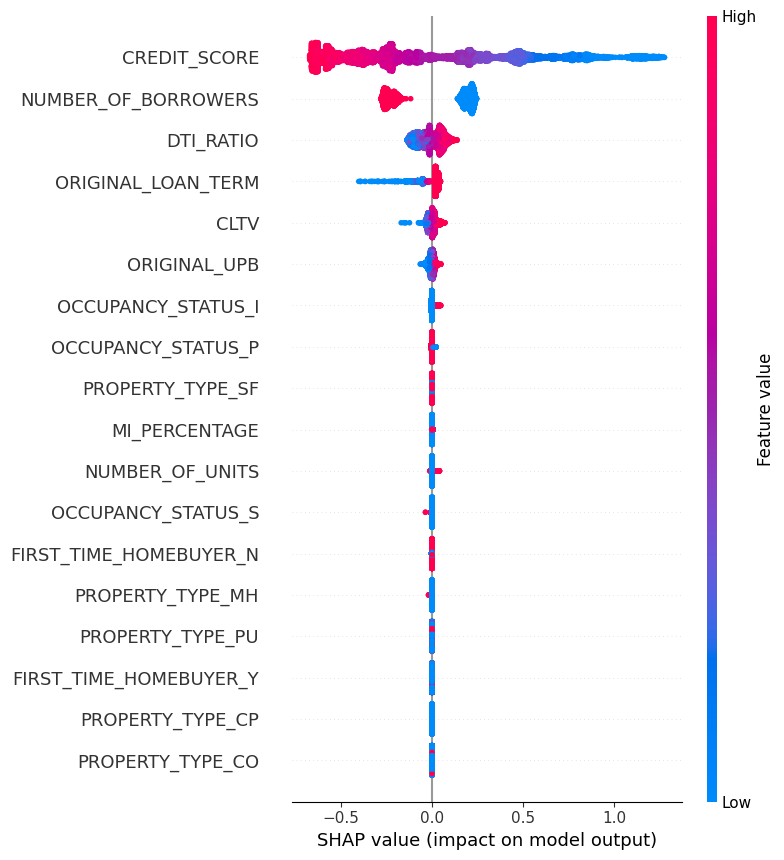

In [ ]:
# Explain Model Predictions using SHAP
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)  # SHAP values for test set

# Summarize SHAP Values
shap.summary_plot(shap_values, X_test)

We retrieve and format SHAP values for one test sample, making it easier to generate human-readable explanations using Llama.

In [ ]:
# Select an example loan case (e.g., first sample in test set)
sample_index = 10  # Change this index if needed
shap_values_sample = shap_values[sample_index].values
sample_features = X_test.iloc[sample_index]

# Convert SHAP values into dictionary format for input
shap_dict = {feature: shap_values_sample[i] for i, feature in enumerate(sample_features.index)}

# Target label for the selected sample
pred_label = y_pred[sample_index]

print("\nSHAP Values for Sample Client:\n", shap_dict)


SHAP Values for Sample Client:
 {'CREDIT_SCORE': np.float64(0.6744336511139408), 'NUMBER_OF_UNITS': np.float64(-6.195724243298173e-05), 'CLTV': np.float64(-0.012177368323318661), 'DTI_RATIO': np.float64(0.013640836470094654), 'ORIGINAL_UPB': np.float64(0.003954916780639905), 'ORIGINAL_LOAN_TERM': np.float64(0.03501838520402089), 'NUMBER_OF_BORROWERS': np.float64(0.2054328467529558), 'MI_PERCENTAGE': np.float64(-4.8993240343406794e-05), 'FIRST_TIME_HOMEBUYER_N': np.float64(1.51152815669775e-05), 'FIRST_TIME_HOMEBUYER_Y': np.float64(0.0), 'OCCUPANCY_STATUS_I': np.float64(-0.0005744176893495023), 'OCCUPANCY_STATUS_P': np.float64(-0.0013040654640644788), 'OCCUPANCY_STATUS_S': np.float64(0.00010000077076256275), 'PROPERTY_TYPE_CO': np.float64(0.0), 'PROPERTY_TYPE_CP': np.float64(0.0), 'PROPERTY_TYPE_MH': np.float64(0.0), 'PROPERTY_TYPE_PU': np.float64(0.0), 'PROPERTY_TYPE_SF': np.float64(-0.0002580513479188085)}


Before proceeding to Llma, let's generate a bar plot of SHAP values for the sampled loan to visualize which features have the most impact on the delinquency prediction.

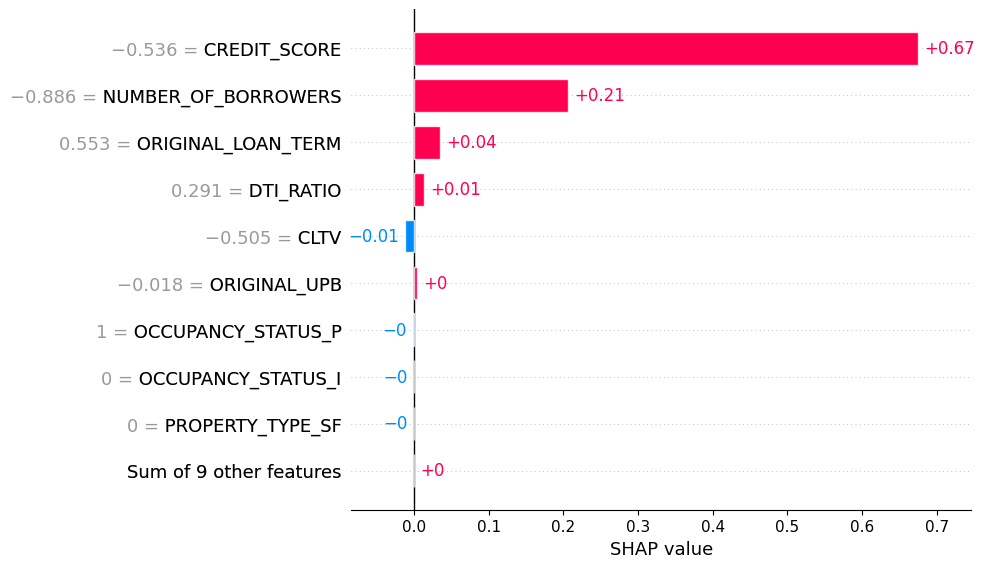

In [ ]:
shap.plots.bar(shap_values[sample_index])

Finally, we format SHAP values into a structured prompt to enable Llama to generate an interpretable explanation of why a loan is predicted as delinquent or not.

We first sort SHAP values by absolute magnitude, prioritizing the most impactful features. Then, we select the top 3 features to keep the explanation concise and focused.

In the prompt, we will:

* Ensure a structured format for clear and consistent LLaMA responses.
* Eliminate unnecessary or unrelated information from the generated output.
* Clearly state the model's decision using SHAP-based reasoning.

In [ ]:
def format_shap_explanation(system_message, sample_features, shap_dict, pred_label, scaler):
    # Convert scaled numerical values back to original values
    original_values = scaler.inverse_transform(sample_features[numerical_columns].values.reshape(1, -1))
    original_feature_values = {feature: original_values[0][i] for i, feature in enumerate(numerical_columns)}

    # Sort SHAP values by absolute magnitude (most impactful features first)
    top_features = sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:3]

    # Generate SHAP explanation text
    shap_text = "\n".join(
        [f"{feature}: SHAP value = {shap_value:.4f}, feature value = {original_feature_values[feature]:.2f}"
         for feature, shap_value in top_features]
    )

    print(shap_text)
    # Define loan delinquency status
    delinquency_status = "likely to be delinquent" if pred_label == 1 else "unlikely to be delinquent"
    print("predicted delinquency: ", delinquency_status)

    # Construct a revised prompt with explicit instructions and structured format
    user_prompt = f"""
The model predicts that the client is {delinquency_status}.

Here are the three most important features influencing the prediction:

{shap_text}

### Instructions:
- Analyze how each of three features contributes to the prediction.
- **Use correct feature names, not feature values.**
- **Strictly follow the structured response format.**
- **SHAP values must be interpreted correctly**:
  - **A positive SHAP value means the feature increases delinquency risk.**
  - **A negative SHAP value means the feature decreases delinquency risk.**

### Response Format:
Feature Name: [Feature Name]
Effect on Risk: Explain whether a higher or lower value increases delinquency risk and why.
SHAP Impact: Clearly state whether the SHAP value shows an increase or decrease in delinquency risk and explain its significance. Provide an individual _REASON_ for the source of risk.

### Example Response
Variable 1:
- Feature Name: Credit Score
- Effect on Risk: A higher credit score reduces delinquency risk because it indicates a strong repayment history and financial responsibility.
- SHAP Impact: The SHAP value **-0.5862** shows that **including credit score for this client decreases** the probability of delinquency, meaning the model considers this a strong indicator of financial reliability. High credit scores mean a good financial behaviour across multiple factors.

Variable 2:
- Feature Name: Employment Length
- Effect on Risk: A higher employment length reduces delinquency risk because it indicates job stability and a stable salary.
- SHAP Impact: The SHAP value **-0.723** shows that **including employment length for this client decreases** the probability of delinquency, meaning the model considers this a strong indicator of financial reliability. A long employment length means the customer has financial stability.

Now begin your structured analysis:
"""


    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


We also define instructions to guide the LLM in analyzing SHAP values for loan delinquency predictions.

In [ ]:
system_message = """
You are a financial risk analyst. Your job is to analyze SHAP values and provide structured, fact-based explanations of the model's predictions.

Guidelines:
1. Interpret SHAP values correctly:
   - **A positive SHAP value means the feature increases delinquency risk.**
   - **A negative SHAP value means the feature decreases delinquency risk.**
2. **Do not contradict basic financial logic**:
   - A **higher credit score should always reduce risk** unless explicitly stated otherwise.
3. **Strictly follow the response format. Do not add extra text or repeat information.**
4. **Do not argue against the given ranking of features.**
5. **Avoid repetition, unnecessary details, or ranking errors.**
6. **Use clear and concise language.**
7. **Analyze the details of each variable and discuss its individual meaning.**
8. **Provide an unique reply for each variable depending on your beliefs on what may be the source of risk. The space for this will be tagged as _REASON_.
"""

prompt = format_shap_explanation(system_message, sample_features, shap_dict, pred_label, scaler)

CREDIT_SCORE: SHAP value = 0.6744, feature value = 683.00
NUMBER_OF_BORROWERS: SHAP value = 0.2054, feature value = 1.00
ORIGINAL_LOAN_TERM: SHAP value = 0.0350, feature value = 360.00
predicted delinquency:  likely to be delinquent


Finally, let's give it a try!

In [ ]:
# Set seed for reproducibility
set_seed(42)

outputs = pipe(prompt, max_new_tokens=512,
               do_sample=True,
               top_p=0.5,
               temperature=0.1,
               repetition_penalty=1)

In [ ]:
display(
    Markdown(
            outputs[0]["generated_text"].split(
                "<|start_header_id|>assistant<|end_header_id|>"
            )[1]
        )
    )



Variable 1:
- Feature Name: Credit Score
- Effect on Risk: A higher credit score reduces delinquency risk because it indicates a strong repayment history and financial responsibility.
- SHAP Impact: The SHAP value **0.6744** shows that **including credit score for this client increases** the probability of delinquency, meaning the model considers this a moderate indicator of financial reliability. A high credit score may indicate a history of on-time payments, but in this case, it seems to have a positive effect on the prediction of delinquency.

Variable 2:
- Feature Name: Number of Borrowers
- Effect on Risk: A higher number of borrowers reduces delinquency risk because it indicates a larger pool of income and financial resources.
- SHAP Impact: The SHAP value **0.2054** shows that **including number of borrowers for this client increases** the probability of delinquency, meaning the model considers this a moderate indicator of financial reliability. A higher number of borrowers may indicate a larger financial burden, which could lead to delinquency.

Variable 3:
- Feature Name: Original Loan Term
- Effect on Risk: A longer original loan term increases delinquency risk because it can lead to higher monthly payments and financial strain.
- SHAP Impact: The SHAP value **0.0350** shows that **including original loan term for this client increases** the probability of delinquency, meaning the model considers this a weak indicator of financial reliability. A longer loan term can lead to a larger debt burden, which may cause financial difficulties.

Pretty good, no? Now you can create your own models!